In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import dc_stat_think as dcst # import dc_stat_think package from Datacamp for bootstrap and ecdf calculation

import scipy.stats as stats

In [2]:
#Import CARB GTI 2018 study on residential meter sets, 
#The csv file only includes measurements where bubbles were seen (data where bubbles were not observed are excluded)
carb = pd.read_csv('CARB_res_meter_set.csv') 

#Import GTI soap test experiment data (roughly 100+ data points)
gti = pd.read_csv('Soap_test_experiments_results.csv')

#Import DOE industrial meter set data

In [3]:
#Add a column in CARB dataset to convert average flow rate from SCFM to SCFH
carb['leak_rate_scfh'] = carb['LEAK.RATE.AVE.SCFM'] * 60

In [4]:
#Selecting only important columns. Repeat measurements, bushing_id, union_id columns are dropped
carb = carb[['DAE.ID', 'COMPANY', 'SITE.ID', 'BUBBLE.SEEN', 'leak_rate_scfh', 'TOOL.USED', 'LEAKING.COMPONENT']]

carb['source'] = 'CARB study'

#Drop rows with missing average leak rate data
carb.dropna(subset=['leak_rate_scfh'], inplace=True, axis='rows')
carb.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source
0,14,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study
2,23,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study
3,27,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study
4,43,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study
7,70,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study


In [5]:
#Rename leak rate columns so it has the same name as the carb data
gti.rename(columns ={'Leak_size_scfh' : 'leak_rate_scfh'}, inplace=True)
gti['source']='GTI lab'
gti.head()

,Experiment_ID,Thread_type,Soap_solution,leak_rate_scfh,Largest_bubble_size_inch,Leak_grade,source
0,1,Bare,MM,0.003,0.0,3.0,GTI lab
1,2,Bare,MM,0.005,0.0,3.0,GTI lab
2,3,Bare,MM,0.007,0.0,3.0,GTI lab
3,4,Bare,MM,0.011,0.0,3.0,GTI lab
4,5,Bare,MM,0.014,0.0,3.0,GTI lab


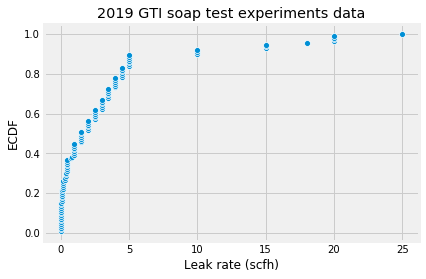

In [6]:
#Plot the cumulative distribution curve of the GTI experimental data (112 data points)
gti_flow_rate, gti_ecdf = dcst.ecdf(gti.leak_rate_scfh)
_ = sns.scatterplot(x=gti_flow_rate, y=gti_ecdf)
_ = plt.title('2019 GTI soap test experiments data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
plt.show()

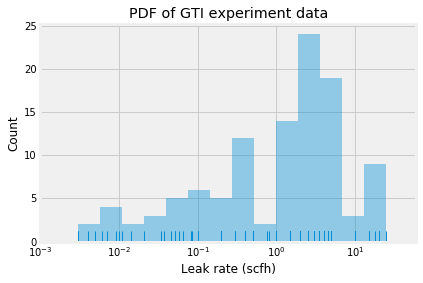

In [7]:
#Plot the pdf of the GTI experiment data

#Plot the pdf of the dataset
LogMin, LogMax = np.log10(gti_flow_rate.min()),np.log10(gti_flow_rate.max())
newBins = np.logspace(LogMin, LogMax, 15)

ax = sns.distplot(gti_flow_rate, kde=False, bins = newBins, rug=True)
ax.set(xscale="log")
_ = plt.title('PDF of GTI experiment data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('Count')
_ = plt.xlim(0.001, 60)

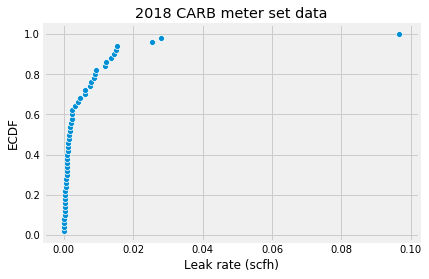

In [8]:
#Plot the cumulative distribution curve of the GTI experimental data (50 data points)
carb_flow_rate, carb_ecdf = dcst.ecdf(carb.leak_rate_scfh)
_ = sns.scatterplot(x=carb_flow_rate, y=carb_ecdf)
_ = plt.title('2018 CARB meter set data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
plt.show()

In [9]:
#Combine the carb and gti datasets 
#Including all the thread types and soap solutions from GTI data
combined = pd.merge(carb, gti,how='outer')

In [10]:
combined.shape

(162, 13)

In [11]:
combined.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source,Experiment_ID,Thread_type,Soap_solution,Largest_bubble_size_inch,Leak_grade
0,14.0,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study,NaN,NaN,NaN,NaN,NaN
1,23.0,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study,NaN,NaN,NaN,NaN,NaN
2,27.0,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study,NaN,NaN,NaN,NaN,NaN
3,43.0,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study,NaN,NaN,NaN,NaN,NaN
4,70.0,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study,NaN,NaN,NaN,NaN,NaN


In [12]:
#Drop every other column except leak_rate_scfh to simplify analysis
combined = combined[['leak_rate_scfh', 'source']]
combined.sort_values(by = ['leak_rate_scfh'], ascending = True, inplace=True)
combined.head()

,leak_rate_scfh,source
25,0.000001,CARB study
10,0.000085,CARB study
33,0.000124,CARB study
1,0.000140,CARB study
31,0.000234,CARB study


In [13]:
#Bins for partitioning the data based on observations of GTI experimental data, 4 categories
ground = 0
max_d = 0.02
max_c = 0.1
max_b = 4  # previously 2
max_a = 25 # previously 25

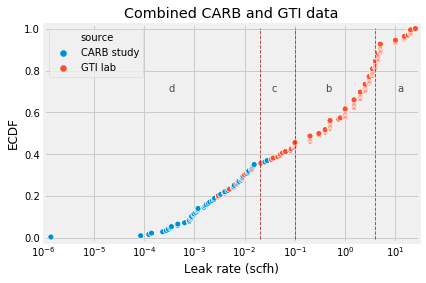

In [14]:
#Plot the ECDF of the combined dataset
combined_flow_rate, combined_ecdf =dcst.ecdf(combined.leak_rate_scfh)
combined['ecdf'] = combined_ecdf
_ = sns.scatterplot(x='leak_rate_scfh', y='ecdf', hue = 'source', data=combined)
_ = _.set(xscale="log")
_ = plt.xlim(0.000001, 30)
_ = plt.title('Combined CARB and GTI data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_d, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 0.7, s='d', color='black', alpha =0.7)
_ = plt.text(x=0.034, y= 0.7, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.4, y= 0.7, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 0.7, s='a', color='black', alpha =0.7)

plt.show()

#There is an outlier on the left side around 1.4E-6 in size from the CARB study
#The largest leak found during the CARB study was 0.097 scfh
#The maximum size tested at GTI is 25 scfh

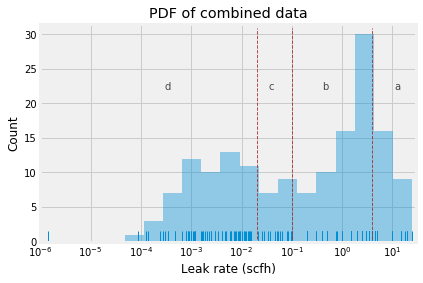

In [15]:
#Plot the pdf of the dataset
LogMin, LogMax = np.log10(combined.leak_rate_scfh.min()),np.log10(combined.leak_rate_scfh.max())
newBins = np.logspace(LogMin, LogMax, 20)

ax = sns.distplot(combined.leak_rate_scfh, kde=False, bins = newBins, rug=True)
ax.set(xscale="log")
_ = plt.title('PDF of combined data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('Count')
_ = plt.xlim(0.000001, 30)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_d, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 22, s='d', color='black', alpha =0.7)
_ = plt.text(x=0.034, y= 22, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.4, y= 22, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 22, s='a', color='black', alpha =0.7)

plt.show()

In [16]:
grp_d = combined[combined.leak_rate_scfh <= max_d]['leak_rate_scfh']
grp_c = combined[(combined.leak_rate_scfh > max_d) & (combined.leak_rate_scfh <= max_c)]['leak_rate_scfh']
grp_b = combined[(combined.leak_rate_scfh > max_c) & (combined.leak_rate_scfh <= max_b)]['leak_rate_scfh']
grp_a = combined[(combined.leak_rate_scfh > max_b)]['leak_rate_scfh']

print("the total number of data points should be 162: ", (grp_d.shape[0] + 
                                                          grp_c.shape[0] + grp_b.shape[0] + 
                                                          grp_a.shape[0]))

#if the total is 162, it means that we are not losing any data

the total number of data points should be 162:  162


In [17]:
d = {   'd':grp_d.shape[0],
        'c':grp_c.shape[0],
        'b':grp_b.shape[0],
        'a':grp_a.shape[0]}

#Create a table with the number of data points for each category
tally = pd.DataFrame(list(d.items()), columns =['category', 'number_of_points'])

In [18]:
mean_d = round(np.mean(grp_d), 4)
mean_c = round(np.mean(grp_c), 4)
mean_b = round(np.mean(grp_b), 4)
mean_a = round(np.mean(grp_a), 4)

median_d = round(np.median(grp_d), 4)
median_c = round(np.median(grp_c), 4)
median_b = round(np.median(grp_b), 4)
median_a = round(np.median(grp_a), 4)

tally['mean_rate_scfh'] = [mean_d, mean_c, mean_b, mean_a]
tally['median_rate_scfh'] = [median_d, median_c, median_b, median_a]
tally['decription'] = ['foams only','small bubbles with or without foams', 'medium to large bubbles', 'bubbles are blown off']
tally

,category,number_of_points,mean_rate_scfh,median_rate_scfh,decription
0,d,57,0.0044,0.0023,foams only
1,c,17,0.0635,0.0570,small bubbles with or without foams
2,b,63,1.8310,1.5000,medium to large bubbles
3,a,25,10.4000,5.0000,bubbles are blown off


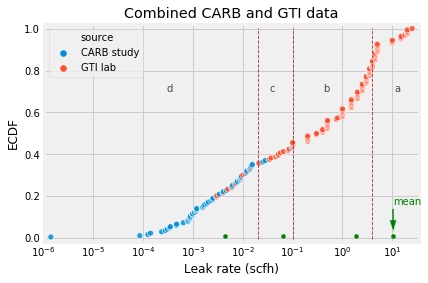

In [19]:
#Plot the ECDF of the combined dataset
_ = sns.scatterplot(x='leak_rate_scfh', y='ecdf', hue ='source', data=combined, alpha =0.85)
_ = _.set(xscale="log")
_ = plt.xlim(0.000001, 35)
_ = plt.title('Combined CARB and GTI data')
_ = plt.xlabel('Leak rate (scfh)')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_d, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_c, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)
_ = plt.axvline(max_b, 0.01, 0.98, lw=0.9, ls ='--', color='brown', alpha=0.9)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0003, y= 0.7, s='d', color='black', alpha =0.7)
_ = plt.text(x=0.034, y= 0.7, s='c', color='black', alpha =0.7)
_ = plt.text(x=0.4, y= 0.7, s='b', color='black', alpha =0.7)
_ = plt.text(x=11, y= 0.7, s='a', color='black', alpha =0.7)

#Add green dots in each group to show where the mean is
_= plt.plot(mean_d, 0.01, color = 'green', marker ='.', markersize = 7)
_= plt.plot(mean_c, 0.01, color = 'green', marker ='.', markersize = 7)
_= plt.plot(mean_b, 0.01, color = 'green', marker ='.', markersize = 7)
_= plt.plot(mean_a, 0.01, color = 'green', marker ='.', markersize = 7)

_= plt.annotate('mean', 
                xy=(mean_a, 0.03), 
                xytext =(mean_a - 0.1, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

In [20]:
#Create the x values and ecdf to plot the ecdf of each 
d_flow, d_ecdf =dcst.ecdf(grp_d)
c_flow, c_ecdf =dcst.ecdf(grp_c)
b_flow, b_ecdf =dcst.ecdf(grp_b)
a_flow, a_ecdf =dcst.ecdf(grp_a)

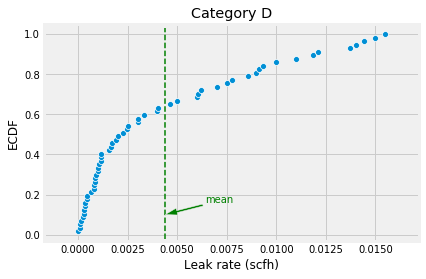

In [21]:
_ = sns.scatterplot(x=d_flow, y=d_ecdf)
_ = plt.title('Category D')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_d, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_d, 0.1), 
                xytext =(mean_d +0.002, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

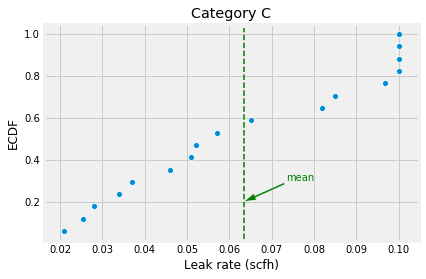

In [22]:
_ = sns.scatterplot(x=c_flow, y=c_ecdf)
_ = plt.title('Category C')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_c, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_c, 0.2), 
                xytext =(mean_c + 0.01, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

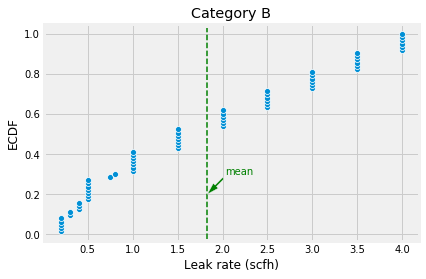

In [23]:
_ = sns.scatterplot(x=b_flow, y=b_ecdf)
_ = plt.title('Category B')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_b, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_b, 0.2), 
                xytext =(mean_b + 0.2, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

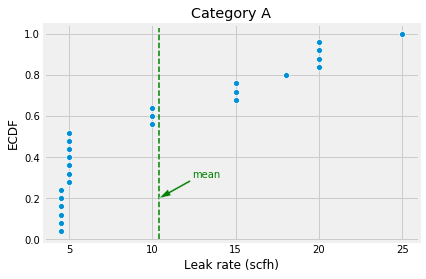

In [24]:
_ = sns.scatterplot(x=a_flow, y=a_ecdf)
_ = plt.title('Category A')
_ = plt.ylabel('ECDF')
_ = plt.xlabel('Leak rate (scfh)')
_= plt.axvline(mean_a, 0.01, 0.98, color = 'green',ls = '--', lw = 1.5)
_= plt.annotate('mean', 
                xy=(mean_a, 0.2), 
                xytext =(mean_a + 2, 0.3),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green')

plt.show()

In [25]:
#Part 2#
# Simulate a non-normal distribution to fit the CARB data
carb.head()

,DAE.ID,COMPANY,SITE.ID,BUBBLE.SEEN,leak_rate_scfh,TOOL.USED,LEAKING.COMPONENT,source
0,14,Socal,17080714.0,Bubbles.Seen,0.008595,Bag,Valve,CARB study
2,23,Socal,17080723.0,Bubbles.Seen,0.000140,NaN,Elbow,CARB study
3,27,Socal,17080727.0,Bubbles.Seen,0.000640,NaN,Bushing,CARB study
4,43,Socal,17080813.0,Bubbles.Seen,0.009125,NaN,Coupling,CARB study
7,70,Socal,17080840.0,Bubbles.Seen,0.015480,NaN,Tee,CARB study


In [26]:
#original leak grade counts for 2018 PG&E MSA leak data
na = 146825
gr_3 = 33201
gr_2 = 2569
gr_1 = 2255

#pre-repair leak grade counts
#na = 146825 + 2967  #include "not available as N/A"
#gr_3 = 29342
#gr_0 = 1004
#gr_2 = 2492 + 1  #include grade 2+
#gr_1 = 2225

#Need to identify the proportion of leaks at PG&E that are grade 3 and 0 as a fraction of total leaks
di = {'N/A': na,
        3: gr_3,
        2: gr_2,
        1: gr_1,
       'Total': na + gr_1 + gr_2 + gr_3
      }

pge_msa = pd.DataFrame(list(di.items()), columns =['Original Leak Grade', 'count'])
pre_total = gr_3 + gr_1 + gr_2
pge_msa['Fraction'] = ['NaN', 
                        round(gr_3 /pre_total, 3),
                        round(gr_2 /pre_total, 3),
                        round(gr_1 /pre_total, 3),
                        (gr_1 + gr_2 + gr_3) /pre_total]

#Fraction of PG&E MSA that has leak grade 0 and 3 out of all leaks
pge_msa.set_index('Original Leak Grade')

,count,Fraction
Original Leak Grade,,
N/A,146825,NaN
3,33201,0.873
2,2569,0.068
1,2255,0.059
Total,184850,1


In [27]:
small_leak_fraction = gr_3/pre_total
print("Fraction of MSA leaks that are grade 0 and 3:", round((small_leak_fraction),3))

Fraction of MSA leaks that are grade 0 and 3: 0.873


In [28]:
# the lognormal function in numpy takes in two key parameters, mean (mu) and stdev (sigma)
#Need to tweak this to get a curve that fits GTI CARB data
# mu = 0.002, sigma =2.2, size = 2000)

# c = 0.55
# sim_data = stats.fisk.rvs(c, loc=0, scale=0.011, size=5000, random_state=60) # random state 60

mu, sigma = (0.01 + np.log(1/200)), 2.6
np.random.seed(57)
sim_data = np.random.lognormal(mu, sigma, size = 2500) # previously np.random.lognormal mu = 0.001, sigma = 2.6, size = 2,500

ecdf_x, y =dcst.ecdf(sim_data)
#cap the data at 25
#ecdf_x = np.clip(ecdf_x, a_min = 0.000001, a_max = 25) # limit the max values in the array
print(ecdf_x.max())
print(ecdf_x.min())

36.82437827236575
9.291089360384986e-07


In [29]:
#create a dataframe for simulated distribution for easier processing
sim= pd.DataFrame(ecdf_x, columns=['leak_rate_scfh'])

#create arrays of data for each leak category
grp_d_sim = sim[(sim.leak_rate_scfh <= max_d)]['leak_rate_scfh']
grp_c_sim = sim[(sim.leak_rate_scfh > max_d) & (sim.leak_rate_scfh <= max_c)]['leak_rate_scfh']
grp_b_sim = sim[(sim.leak_rate_scfh > max_c) & (sim.leak_rate_scfh <= max_b)]['leak_rate_scfh']
grp_a_sim = sim[(sim.leak_rate_scfh > max_b)]['leak_rate_scfh']

In [30]:
d_sim = {'d':grp_d_sim.shape[0],
        'c':grp_c_sim.shape[0],
        'b':grp_b_sim.shape[0],
        'a':grp_a_sim.shape[0]}

#Create a table with the number of data points for each category
tally_sim = pd.DataFrame(list(d_sim.items()), columns =['category', 'number_of_points'])

In [31]:
mean_d = round(np.mean(grp_d_sim), 4)
mean_c = round(np.mean(grp_c_sim), 4)
mean_b = round(np.mean(grp_b_sim), 4)
mean_a = round(np.mean(grp_a_sim), 4)

median_d = round(np.median(grp_d_sim), 4)
median_c = round(np.median(grp_c_sim), 4)
median_b = round(np.median(grp_b_sim), 4)
median_a = round(np.median(grp_a_sim), 4)

tally_sim['simulated_fraction'] = tally_sim['number_of_points']/tally_sim.number_of_points.sum()
tally_sim['mean_rate_scfh'] = [mean_d, mean_c, mean_b, mean_a]
tally_sim['median_rate_scfh'] = [median_d, median_c, median_b, median_a]
tally_sim['description'] = ['foams with little or no bubbles','cluster of small bubbles', 'small to medium bubbles', 'soap solution is blown off']
tally_sim['msa_leak_fraction'] = np.divide([0, gr_3, gr_2, gr_1], pre_total)
tally_sim['msa_leak_fraction'] = round(tally_sim['msa_leak_fraction'], 4)

tally_sim = tally_sim[['category', 'description', 'number_of_points', 'mean_rate_scfh', 'median_rate_scfh', 'simulated_fraction', 'msa_leak_fraction']]

In [32]:
tally_sim

,category,description,number_of_points,mean_rate_scfh,median_rate_scfh,simulated_fraction,msa_leak_fraction
0,d,foams with little or no bubbles,1760,0.0040,0.0019,0.7040,0.0000
1,c,cluster of small bubbles,405,0.0466,0.0419,0.1620,0.8731
2,b,small to medium bubbles,318,0.5347,0.2744,0.1272,0.0676
3,a,soap solution is blown off,17,9.5831,7.4034,0.0068,0.0593


In [33]:
#Add a new row below with grouped category d,c
tally_sim.loc[4]=tally_sim.loc[0] + tally_sim.loc[1]
tally_sim.loc[4, 'category'] = 'd, c'
tally_sim.loc[4, 'mean_rate_scfh'] = round((np.sum(grp_d_sim) + np.sum(grp_c_sim))/(len(grp_d_sim)+ len(grp_c_sim)), 4)
tally_sim.loc[4, 'median_rate_scfh'] = round(np.median(grp_d_sim.append(grp_c_sim)), 4)
tally_sim.loc[4, 'description'] = 'foams or small bubbles'

In [34]:
tally_sim

,category,description,number_of_points,mean_rate_scfh,median_rate_scfh,simulated_fraction,msa_leak_fraction
0,d,foams with little or no bubbles,1760,0.0040,0.0019,0.7040,0.0000
1,c,cluster of small bubbles,405,0.0466,0.0419,0.1620,0.8731
2,b,small to medium bubbles,318,0.5347,0.2744,0.1272,0.0676
3,a,soap solution is blown off,17,9.5831,7.4034,0.0068,0.0593
4,"d, c",foams or small bubbles,2165,0.0120,0.0033,0.8660,0.8731


In [35]:
#Remove rows d & c from tally and change the index of the last 
tally_sim_no = tally_sim.iloc[2:]
as_list = tally_sim_no.index.tolist()
idx = as_list.index(4)
as_list[idx] = 1
tally_sim_no.index = as_list
tally_sim_no = tally_sim_no.sort_index()

In [36]:
tally_sim_no

,category,description,number_of_points,mean_rate_scfh,median_rate_scfh,simulated_fraction,msa_leak_fraction
1,"d, c",foams or small bubbles,2165,0.0120,0.0033,0.8660,0.8731
2,b,small to medium bubbles,318,0.5347,0.2744,0.1272,0.0676
3,a,soap solution is blown off,17,9.5831,7.4034,0.0068,0.0593


In [37]:
#Shrink CARB data so the ECDF is capped at the fraction of leaks that are in grade 0 and 3. 
# We do this because CARB data has small leaks with the largest one being 0.1 scfh so it represents leaks in
# the small categories
capped_carb_ecdf = carb_ecdf*small_leak_fraction

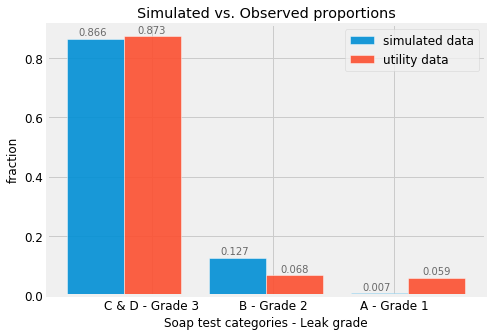

In [38]:
#Plot pdf of simulated distribution versus PG&E data
# set width of bar
barWidth = 0.4
 
# set height of bar
bars1 = list(tally_sim_no.simulated_fraction)
bars2 = list(tally_sim_no.msa_leak_fraction)
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(7,5))
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='simulated data', alpha=0.9)
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='utility data', alpha=0.9)
 
# Add xticks on the middle of the group bars
plt.xlabel('Soap test categories - Leak grade', fontsize='large')
plt.xticks([r*0.85 + barWidth for r in range(len(bars1))], ['C & D - Grade 3', 'B - Grade 2', 'A - Grade 1'])
plt.ylabel('fraction', fontsize='large')
plt.title('Simulated vs. Observed proportions')

#add labels above each bar
for i, v in enumerate(bars1):
    plt.text(i-0.12, v+0.01, str(round(v,3)), color='dimgray', fontsize='medium')
    
for i, v in enumerate(bars2):
    plt.text(i+0.3, v+0.01, str(round(v,3)), color='dimgray', fontsize='medium')
    
# Create legend & Show graphic
plt.legend(fontsize='large')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()


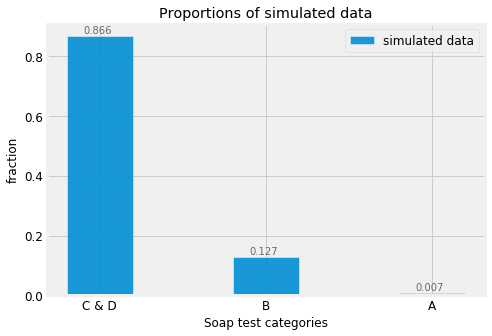

In [39]:
# Make the plot
plt.figure(figsize=(7,5))
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='simulated data', alpha=0.9)

# Add xticks on the middle of the group bars
plt.xlabel('Soap test categories', fontsize='large')
plt.xticks([r for r in range(len(bars1))], ['C & D', 'B', 'A'])
plt.ylabel('fraction', fontsize='large')
plt.title('Proportions of simulated data')

#add labels above each bar
for i, v in enumerate(bars1):
    plt.text(i-0.1, v+0.01, str(round(v,3)), color='dimgray', fontsize='medium')
       
# Create legend & Show graphic
plt.legend(fontsize='large')
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

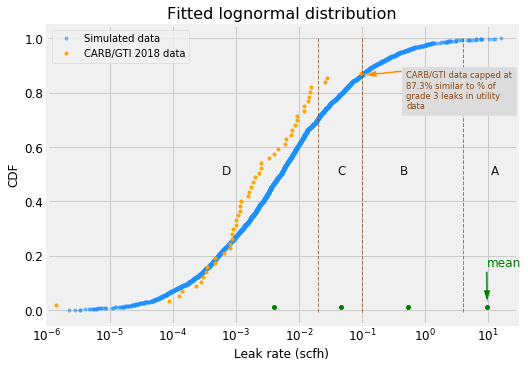

In [40]:
_=plt.figure(figsize=(7.5,5.5))
_=plt.semilogx(ecdf_x, y, marker ='.', linestyle='none', alpha=0.5, color ='dodgerblue')
_=plt.semilogx(carb_flow_rate, capped_carb_ecdf, marker='.', linestyle='none', color='orange')
_=plt.xlim(0.000001, 28)
_=plt.legend(['Simulated data', 'CARB/GTI 2018 data'], loc ='upper left', fontsize = 'medium')
_=plt.xlabel('Leak rate (scfh)')
_=plt.ylabel('CDF')
_=plt.title('Fitted lognormal distribution', fontsize=16)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_d, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)
_ = plt.axvline(max_c, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)
_ = plt.axvline(max_b, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0006, y= 0.5, s='D', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=0.04, y= 0.5, s='C', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=0.4, y= 0.5, s='B', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=11, y= 0.5, s='A', color='black', alpha =0.9, fontsize=12)

#Add green dots in each group to show where the mean is
_= plt.plot(mean_d, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_c, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_b, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_a, 0.01, color = 'green', marker ='.', markersize = 8)

_= plt.annotate('mean', 
                xy=(mean_a, 0.03), 
                xytext =(mean_a - 0.1, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green',
                fontsize =12)

_= plt.annotate('CARB/GTI data capped at\n87.3% similar to % of\ngrade 3 leaks in utility\ndata', 
                xy=(0.11, 0.865), 
                xytext =(0.5, 0.74),
                arrowprops = {'facecolor': 'darkorange', 'headwidth': 7, 'width': 2}, 
                color='saddlebrown', fontsize='small', alpha = 0.99, backgroundcolor= 'gainsboro')


plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

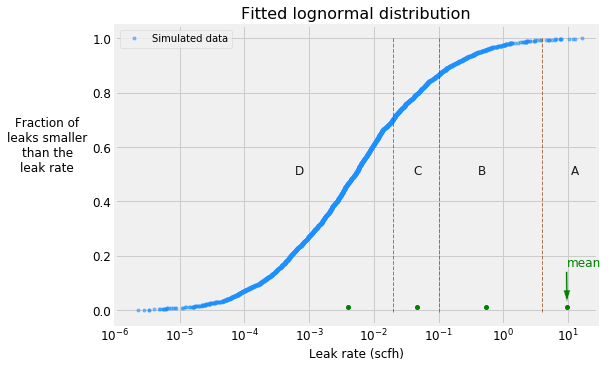

In [41]:
_=plt.figure(figsize=(7.7,5.5))
_=plt.semilogx(ecdf_x, y, marker ='.', linestyle='none', alpha=0.5, color ='dodgerblue')
_=plt.xlim(0.000001, 28)
_=plt.legend(['Simulated data'], loc ='upper left', fontsize = 'medium')
_=plt.xlabel('Leak rate (scfh)')
_=plt.ylabel('Fraction of\nleaks smaller\nthan the\nleak rate', rotation =0, fontsize = 12, labelpad = 45)
_=plt.title('Fitted lognormal distribution', fontsize=16)

#Draw vertical lines to mark the ranges for each bin (based on observations in GTI experiment)
_ = plt.axvline(max_d, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)
_ = plt.axvline(max_c, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)
_ = plt.axvline(max_b, 0.04, 0.96, lw=1, ls ='--', color='saddlebrown', alpha=0.7)

#Draw text in the plot to mark regions of each bin
_ = plt.text(x=0.0006, y= 0.5, s='D', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=0.04, y= 0.5, s='C', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=0.4, y= 0.5, s='B', color='black', alpha =0.9, fontsize=12)
_ = plt.text(x=11, y= 0.5, s='A', color='black', alpha =0.9, fontsize=12)

#Add green dots in each group to show where the mean is
_= plt.plot(mean_d, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_c, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_b, 0.01, color = 'green', marker ='.', markersize = 8)
_= plt.plot(mean_a, 0.01, color = 'green', marker ='.', markersize = 8)

_= plt.annotate('mean', 
                xy=(mean_a, 0.03), 
                xytext =(mean_a - 0.1, 0.16),
                arrowprops = {'facecolor': 'green', 'headwidth': 7, 'width': 2}, 
                color='green',
                fontsize =12)

plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [42]:
import scipy.stats as stats  
fit_s, fit_loc, fit_scale=stats.lognorm.fit(sim_data) # let scipy estimate best parameters using Maximum Likelihood 
#Estimation
print(fit_s, fit_loc, np.log(fit_scale)) #fit_s is sigma or std, scale is exp(mu), so mu is ln(scale)

# the values are close to actual parameters

2.655704079255669 6.220744125609563e-07 -5.281543897516893


In [43]:
# try to fit lognormal distribution but end up with a negative value
fit_s, fit_loc, fit_scale=stats.lognorm.fit(carb_flow_rate*200, floc=0) 
print(fit_s, fit_loc, np.log(fit_scale)) #for lognormal = sigma, loc, mu/mean

1.8554104114340293 0.0 -1.0238173512783655


In [44]:
fit_s, fit_loc, fit_scale=stats.weibull_min.fit(carb_flow_rate*200, floc=0) 
print(fit_c, fit_loc, np.log(fit_scale)) #for lognormal = sigma, loc, mu/mean

NameError: name 'fit_c' is not defined

In [ ]:
"""Testing the best distribution for the carb dataset using the full list 
of the current scipy.stats distributions and returns the distribution with 
the least SSE (Sum of Square Error) between the distribution's histogram 
and the data's histogram.

https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
"""

%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(carb_flow_rate * 200)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'CARB leak data\n All Fitted Distributions')
ax.set_xlabel(u'Leak flow rate (scfh)')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'CARB leak rates with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Leak rate (scfh)')
ax.set_ylabel('Frequency')
ax.set_xscale('log')

In [ ]:
'''
log-logistic or fisk seems to be the best distribution for the carb dataset 
It is similar to a lognormal distribution but has heavier tails
https://en.wikipedia.org/wiki/Log-logistic_distribution
'''
fit_c, fit_loc, fit_scale=stats.fisk.fit(carb_flow_rate * 200, floc=0) 
print(fit_c, fit_loc, fit_scale) #for fisk = c, loc, scale

In [ ]:
# To save simulated distribution data into csv file
# dict_ecdf = {"x": ecdf_x, 
#             "ecdf": y}
# ecdf_df = pd.DataFrame(dict_ecdf)

# ecdf_df.to_csv("simulated_ecdf_data.csv")